# Classifying with Decision Trees, Random Forest and Gradient Boost

In [35]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

## Loading data (Iris-Data)

In [2]:
# Loading data and extract feature-data and target-data
iris_dict = load_iris(as_frame=True)
iris_features = iris_dict['data']
iris_target = iris_dict['target']

# Inspect, if data is biased towards some target class
print(f'{iris_target.value_counts()}\nTarget classes are equally distributed.')

# Splitting into test and training data, no weights, as class representation is equal and will most
strat_splitter = StratifiedKFold(n_splits=5, shuffle=True)
# Create variables for one train/test-split and use just last of obtained splits
X_train, X_test, y_train, y_test = (pd.DataFrame([]) for i in range(4))
split = next(strat_splitter.split(iris_features, iris_target))
X_train = iris_features.iloc[split[0]]
X_test = iris_features.iloc[split[1]]
y_train = iris_target.iloc[split[0]]
y_test = iris_target.iloc[split[1]]

0    50
1    50
2    50
Name: target, dtype: int64
Target classes are equally distributed.


## Decision Tree Classifier

Accuracy on training data set:	96.7%
Accuracy on test data set:	100.0%
Result depends on chosen train/test-split. Crossvalidation is used to overcome this and tune hyperparameters.

Score on crossvalidation is: 96.0% +/- 5.3%


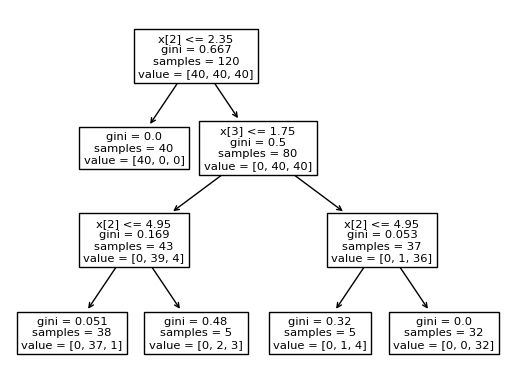

In [3]:
tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
# Iris-dataset is 
tree.fit(X_train, y_train)
# Compare score on training data with score on test data, to check for overfitting
print(f'Accuracy on training data set:\t{tree.score(X_train, y_train):.1%}')
print(f'Accuracy on test data set:\t{tree.score(X_test, y_test):.1%}')
print('Result depends on chosen train/test-split. Crossvalidation is used to overcome this and \
tune hyperparameters.')
# Plot tree
plot_tree(tree)
# Generate train/test-split with approx. preserved distribution of target classes and do crossvalidation
tree_cross_score = cross_validate(tree, X=iris_features, y=iris_target, cv=10)['test_score']
print(f'\nScore on crossvalidation is: {tree_cross_score.mean():.1%} +/- {tree_cross_score.std():.1%}')

# Random forest on energy data

In [4]:
# Loading the raw data
df_raw = pd.read_csv('energy_victoria_aus.csv')

In [5]:
# Tweak-function to manipulate raw data into cleaned-up data
def tweak_energy_victoria(df_):
    return (df_.rename(lambda s: s.lower(), axis=1) #only lower case in column names
               .assign(rainfall=lambda s: s.rainfall.interpolate(), #interpolate 3 missing values
                       solar_exposure=lambda s: s.solar_exposure.interpolate(),#interpolate 1 missing value
                       # Convert school_day and holiday to bool
                       school_day=lambda s: s.school_day.replace({'Y':True, 'N':False}).astype('bool'),
                       holiday=lambda s: s.holiday.replace({'Y':True, 'N':False}).astype('bool'))
           )

In [6]:
df = tweak_energy_victoria(df_raw)
df.head()

date      demand        rrp  demand_pos_rrp  rrp_positive  \
0  2015-01-01   99635.030  25.633696       97319.240     26.415953   
1  2015-01-02  129606.010  33.138988      121082.015     38.837661   
2  2015-01-03  142300.540  34.564855      142300.540     34.564855   
3  2015-01-04  104330.715  25.005560      104330.715     25.005560   
4  2015-01-05  118132.200  26.724176      118132.200     26.724176   

   demand_neg_rrp  rrp_negative  frac_at_neg_rrp  min_temperature  \
0        2315.790     -7.240000         0.020833             13.3   
1        8523.995    -47.809777         0.062500             15.4   
2           0.000      0.000000         0.000000             20.0   
3           0.000      0.000000         0.000000             16.3   
4           0.000      0.000000         0.000000             15.0   

   max_temperature  solar_exposure  rainfall  school_day  holiday  
0             26.9            23.6       0.0       False     True  
1             38.8            26.8       0.0       False    False  
2             38.2            26.5       0.0       False    False  
3             21.4            25.2       4.2       False    False  
4             22.0            30.7       0.0       False    False

### Tasks:
1) Predict demand based on weather conditions and school-day/holiday information
2) Predict price (rrp) based on demand, weather conditions and school-day/holiday information

1) Solving as a random forest regressor task. Data can be shuffled, as no time series is to be predicted.

In [7]:
# Split off test data
train_X_full, X_test, train_y_full, y_test = train_test_split(df[['min_temperature', 'max_temperature', 
                                                                   'solar_exposure', 'rainfall', 
                                                                   'school_day', 'holiday']], 
                                                              df[['demand']], test_size=0.2, 
                                                              shuffle=True)
# Split off validation data
X_train, X_val, y_train, y_val = train_test_split(train_X_full, train_y_full, test_size=0.2)

In [89]:
# Data inspection and choice of transformation
pd.plotting.scatter_matrix(X_train[num_attr].assign(rainfall=lambda s: np.log(s.rainfall+1),
                                                    max_temperature=lambda s: np.log(s.max_temperature),
                                                    solar_exposure=lambda s: (s.solar_exposure**.7)), figsize=(12, 8))

array([[<Axes: xlabel='min_temperature', ylabel='min_temperature'>,
        <Axes: xlabel='max_temperature', ylabel='min_temperature'>,
        <Axes: xlabel='solar_exposure', ylabel='min_temperature'>,
        <Axes: xlabel='rainfall', ylabel='min_temperature'>],
       [<Axes: xlabel='min_temperature', ylabel='max_temperature'>,
        <Axes: xlabel='max_temperature', ylabel='max_temperature'>,
        <Axes: xlabel='solar_exposure', ylabel='max_temperature'>,
        <Axes: xlabel='rainfall', ylabel='max_temperature'>],
       [<Axes: xlabel='min_temperature', ylabel='solar_exposure'>,
        <Axes: xlabel='max_temperature', ylabel='solar_exposure'>,
        <Axes: xlabel='solar_exposure', ylabel='solar_exposure'>,
        <Axes: xlabel='rainfall', ylabel='solar_exposure'>],
       [<Axes: xlabel='min_temperature', ylabel='rainfall'>,
        <Axes: xlabel='max_temperature', ylabel='rainfall'>,
        <Axes: xlabel='solar_exposure', ylabel='rainfall'>,
        <Axes: xlabel='rain

In [26]:
# Preprocess data
num_attr = ['min_temperature', 'max_temperature', 'solar_exposure', 'rainfall']
cat_attr = ['school_day', 'holiday']

num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer())
])
#preprocessing = ColumnTransformer([
#    ('standardize', StandardScaler()), ()])

In [22]:
# Train linear model for benchmarking the more sophisticated models
X_train

min_temperature  max_temperature  solar_exposure  rainfall  school_day  \
84                9.8             18.0             9.9       0.4        True   
1750              9.5             15.2             9.6       4.4        True   
1781             10.8             16.2            24.1       0.0        True   
1778             12.1             22.4            19.7       0.8        True   
1328              8.6             12.4             7.7       1.2        True   
...               ...              ...             ...       ...         ...   
1764             14.2             33.7            25.5       0.0        True   
1903             17.7             28.3             9.1       0.0        True   
705              12.8             20.8            24.2       0.0        True   
954              10.3             17.9             9.9       2.8        True   
620               9.9             13.6             7.0       1.6        True   

      holiday  
84      False  
1750    False  
1781    False  
1778    False  
1328    False  
...       ...  
1764    False  
1903    False  
705     False  
954     False  
620     False  

[1347 rows x 6 columns]